# 2 Data

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import wrds
#db=wrds.Connection(wrds_username='sahakyan')

In [ ]:
#---------------------------------------------
# Risk Free Rate 
#---------------------------------------------
Rf=db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='1964-01-01'
            and mcaldt<='2023-12-31'""", date_cols=['mcaldt'])
Rf['tmytm']=Rf['tmytm']/12/100
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})


#---------------------------------------------
# Value Weighted Index Returns
#---------------------------------------------
Rm=db.raw_sql("""select  date,vwretd from crsp.msi 
                where date>='1964-01-01' and date<='2023-12-31'
                """,date_cols=['date'])
Rm = Rm.rename(columns={'vwretd':'Rm'})

#---------------------------------------------
# Stock Returns 
#---------------------------------------------
stock_data = db.raw_sql("""
                    select a.permno, a.date, 
                      b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1964' and '12/31/2023'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 
stock_data=stock_data.drop(['shrcd','exchcd'],axis=1)
stock_data = stock_data.rename(columns={'ret':'Rn'})
stock_data['mcap'] = np.abs(stock_data['prc'])*stock_data['shrout']
stock_data['mcap_l'] = stock_data.groupby(['permno'])['mcap'].shift(1)


#---------------------------------------------
# Merge Data 
#---------------------------------------------
data = pd.merge(stock_data, Rf, on=['date'], how='left')
data = pd.merge(data, Rm, on=['date'], how='left')
data['const'] = 1
data['Rn_e'] = data['Rn']-data['rf']
data['Rm_e'] = data['Rm']-data['rf']
data.to_csv('data.csv', sep=';',index=False) # export data

# 3 Betting against Beta strategy (BaB)

#### (a) Computation of time-varying Beta

In [2]:
# load data
data = pd.read_csv('data_with_industries.csv', sep=',')
data['date'] = pd.to_datetime(data['date'])
# get rid of the day in the date
data['date'] = data['date'].dt.to_period('M')
data['date'] = data['date'].dt.to_timestamp()

In [3]:
data = data.sort_values(by=['permno', 'date']).reset_index(drop=True)

In [4]:
# (a)
# 0. Remove nans
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

# 2. Estimate Rolling Betas
cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(window = 60, min_periods=36).cov()
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

# 3. Merge betas with data
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
data = data.merge(beta_n, on=['permno','date'], how='left')

# get rid of nan values
data = data.dropna(subset=['beta']).copy()

# 4. Remove outliers
data['beta'] = data['beta'].clip(data['beta'].quantile(0.05),data['beta'].quantile(0.95))

In [5]:
len(data)

1118619

#### (B) Beta Deciles

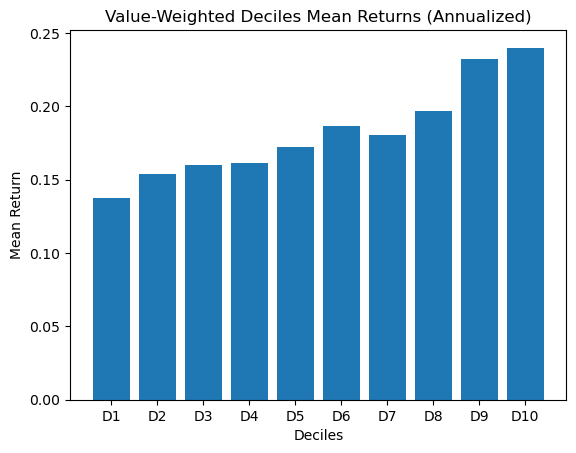

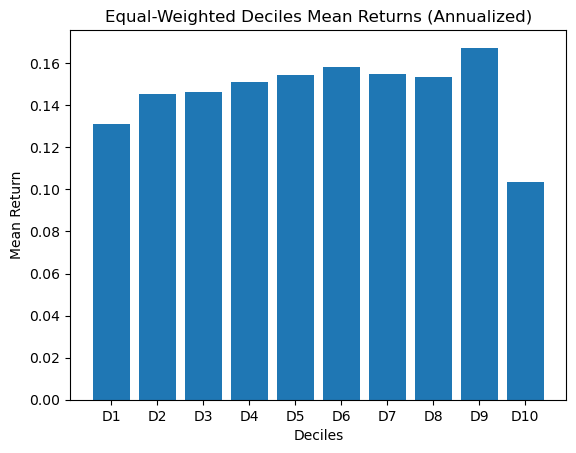

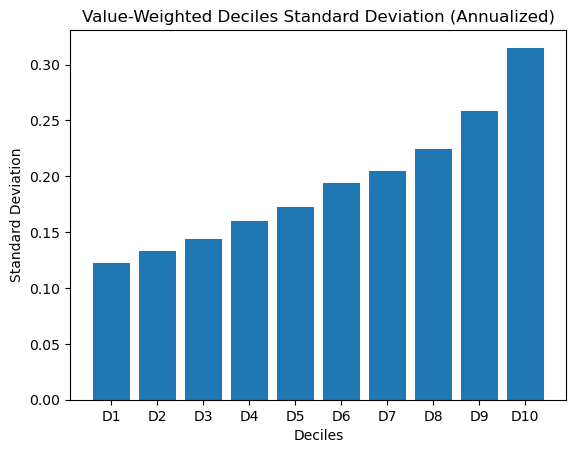

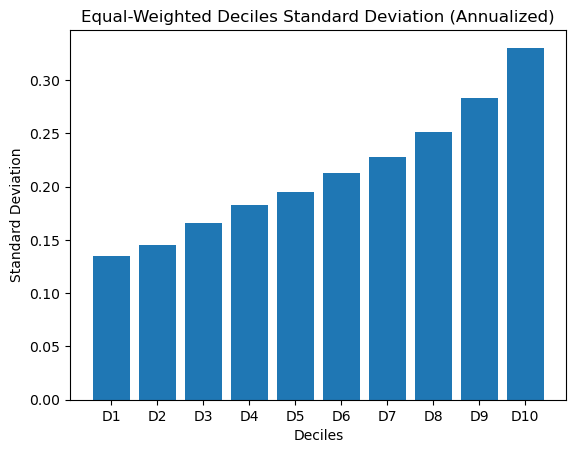

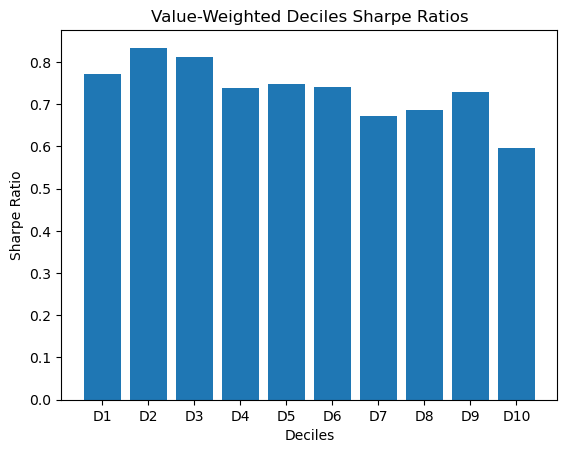

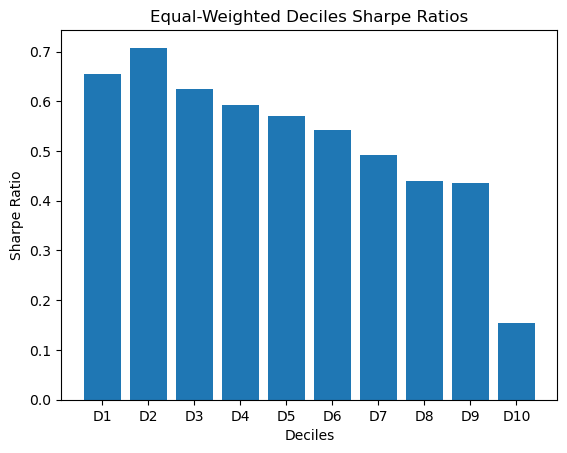

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# (b)
# 1. Deciles
data['beta_Q'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
# 2. Market Weights within deciles
data['vw_Q'] = data['mcap'] / data.groupby(['date', 'beta_Q'])['mcap'].transform('sum')

# 3. VW Portfolios
data['beta_ret_vw'] = data['vw_Q'] * data['Rn']
ret_vw = data.groupby(['date', 'beta_Q'])['beta_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_Q')['beta_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date', 'beta_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_Q')['Rn'].mean()

# Calculate standard deviations
vw_ret_std = ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
ew_ret_std = ret_ew.groupby('beta_Q')['Rn'].std()

# Compute the Sharpe Ratios for each decile

# compute the risk-free rate
rf = data.groupby(['date', 'beta_Q'])['rf'].mean().reset_index()

# compute the excess returns
ret_vw['excess'] = ret_vw['beta_ret_vw'] - rf['rf']
ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

# compute the Sharpe Ratios
vw_sharpe = ret_vw.groupby('beta_Q')['excess'].mean() / ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
ew_sharpe = ret_ew.groupby('beta_Q')['excess'].mean() / ret_ew.groupby('beta_Q')['Rn'].std()

# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

directory = 'Plots/Part3'

#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + '/vw_ret_mean.png')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + '/ew_ret_mean.png')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + '/vw_ret_std.png')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + '/ew_ret_std.png')
plt.show()

# Plot VW Sharpe Ratios
plt.bar(deciles, vw_sharpe* np.sqrt(12))
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + '/vw_sharpe.png')
plt.show()

# Plot EW Sharpe Ratios
plt.bar(deciles, ew_sharpe* np.sqrt(12))
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + '/ew_sharpe.png')
plt.show()

TODO
- Question: Summarize our findings. Is the evidence consistent with the CAPM?
- Answer:

#### (c/d) Construct BAB factor

In [7]:
# Weights
data['z'] = data.groupby('date')['beta'].transform(lambda x: x.rank())
data['z_'] = data['z']-data.groupby('date')['z'].transform('mean')
data['k'] = np.abs(data['z_'])
data['k'] = 2/data.groupby('date')['k'].transform('sum')
data['w_H'] = data['k'] * data['z_'] * (data['z_']>0) 
data['w_L'] = -data['k'] * data['z_'] * (data['z_']<0)

# Weighted returns and beta
data['beta_H'] = data['w_H'] * data['beta']
data['beta_L'] = data['w_L'] * data['beta']
data['R_H'] = data['w_H'] * data['Rn']
data['R_L'] = data['w_L'] * data['Rn']
data['R_H_e'] = data['w_H'] * data['Rn_e']
data['R_L_e'] = data['w_L'] * data['Rn_e']

# Sum up the weighted returns and betas but not the rf
BAB = data.groupby('date')[['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()
BAB['rf'] = data.groupby('date')['rf'].mean().reset_index()['rf']
# unlevered returns
BAB['BAB2'] = (BAB['R_L_e']/BAB['beta_L']) - ( BAB['R_H_e']/BAB['beta_H'] )

# Create factor weights for exercise 7
data['w_bab'] = 1 / data['beta']
data['w_bab'] = data['w_bab'] / data.groupby('date')['w_bab'].transform('sum')

In [8]:
data

,permno,date,Rn,shrout,prc,SIC,mcap,mcap_l,rf,Rm,...,k,w_H,w_L,beta_H,beta_L,R_H,R_L,R_H_e,R_L_e,w_bab
36,10001,2013-01-01,0.062701,8157.0,9.87,4925,80509.59,81080.58,0.000051,0.054142,...,0.000005,-0.000000,0.002511,-0.000000,0.001167,-0.000000,0.000157,-0.000000,0.000157,0.001538
37,10001,2013-02-01,0.011651,8157.0,9.94,4925,81080.58,83201.40,0.000040,0.008282,...,0.000005,-0.000000,0.002454,-0.000000,0.001189,-0.000000,0.000029,-0.000000,0.000028,0.001485
38,10001,2013-03-01,0.030684,8157.0,10.20,4925,83201.40,86668.70,0.000034,0.035295,...,0.000005,-0.000000,0.002449,-0.000000,0.001186,-0.000000,0.000075,-0.000000,0.000075,0.001490
39,10001,2013-04-01,0.017157,8390.0,10.33,4925,86668.70,86249.20,0.000013,0.014939,...,0.000005,-0.000000,0.002473,-0.000000,0.001205,-0.000000,0.000042,-0.000000,0.000042,0.001482
40,10001,2013-05-01,-0.000484,8390.0,10.28,4925,86249.20,89064.10,0.000013,0.019128,...,0.000005,-0.000000,0.002471,-0.000000,0.001204,0.000000,-0.000001,0.000000,-0.000001,0.001484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420785,93426,2023-08-01,-0.037156,12581.0,36.02,3676,453167.62,367146.00,0.004463,-0.020605,...,0.000006,0.000468,-0.000000,0.000615,-0.000000,-0.000017,0.000000,-0.000019,0.000000,0.000623
1420786,93426,2023-09-01,-0.067740,12581.0,33.58,3676,422469.98,395136.96,0.004472,-0.047390,...,0.000006,0.000426,-0.000000,0.000556,-0.000000,-0.000029,0.000000,-0.000031,0.000000,0.000633
1420787,93426,2023-10-01,-0.108993,12581.0,29.92,3676,376423.52,405680.64,0.004475,-0.028867,...,0.000006,0.000392,-0.000000,0.000510,-0.000000,-0.000043,0.000000,-0.000045,0.000000,0.000636
1420788,93426,2023-11-01,0.019051,12510.0,30.49,3676,381429.90,387805.47,0.004455,0.092057,...,0.000006,0.000406,-0.000000,0.000529,-0.000000,0.000008,-0.000000,0.000006,-0.000000,0.000639


In [9]:
# Create new a new dataframe to store the bab weights
factor_weights = data[['date', 'permno', 'w_bab']]

In [10]:
# Merge Market and Risk free Rate
tmp = pd.merge(BAB,data[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['alpha'] = 1

# Alpha and Beta
import statsmodels.api as sm
tmp = tmp.dropna()
OLS_Reg = sm.OLS(tmp['BAB2'], tmp[['alpha','Rm_e']]).fit()

# Report the mean,standard deviation, and sharpe ratio and CAPM alpha of the BAB factor
print('Mean:', tmp['BAB2'].mean()*12)
print('Standard Deviation:', tmp['BAB2'].std()*np.sqrt(12))
# Annualize the Sharpe ratio and CAPM alpha
print('Sharpe ratio:', tmp['BAB2'].mean()/tmp['BAB2'].std()*np.sqrt(12))
print('Monthly CAPM Alpha:', OLS_Reg.params['alpha']*12)



Mean: 0.1187293114635383
Standard Deviation: 0.14074653526654443
Sharpe ratio: 0.8435682714227377
Monthly CAPM Alpha: 0.08334137801182329


Save factor for our investing strategy

In [11]:
print(len(BAB))
strat = BAB[['date','rf','BAB2']]
strat

682


,date,rf,BAB2
0,1967-01-01,0.003788,0.074142
1,1967-02-01,0.003737,0.017379
2,1967-03-01,0.003385,0.012749
3,1967-04-01,0.002877,0.022554
4,1967-05-01,0.002707,0.004873
...,...,...,...
677,2023-08-01,0.004463,-0.015452
678,2023-09-01,0.004472,-0.043764
679,2023-10-01,0.004475,0.005450
680,2023-11-01,0.004455,0.034858


# 4 Momentum Strategy (Mom)

In [12]:
# Load data
data = pd.read_csv('data_with_industries.csv', delimiter=',')
#drop column mcap_l 
data = data.drop(columns=['mcap_l'])
#drop nan in Rn column
data = data.dropna(subset=['Rn'])
# Convert date to datetime
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.to_period('M')
data['date'] = data['date'].dt.to_timestamp()
# Sort the data by permno and date
data = data.sort_values(['permno', 'date']).reset_index(drop=True)
display(data.isna().sum())
data

permno       0
date         0
Rn           0
shrout       0
prc          0
SIC          0
mcap         0
rf        2076
Rm           0
const        0
Rn_e      2076
Rm_e      2076
NoDur        0
Durbl        0
Manuf        0
Enrgy        0
Chems        0
BusEq        0
Telcm        0
Utils        0
Shops        0
Hlth         0
Money        0
Other        0
dtype: int64

,permno,date,Rn,shrout,prc,SIC,mcap,rf,Rm,const,...,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
0,10001,2009-12-01,0.162621,4361.0,10.3000,4925,44918.3000,0.000032,0.028475,1,...,0,0,0,0,0,1,0,0,0,0
1,10001,2010-01-01,-0.018932,4361.0,10.0600,4925,43871.6600,0.000013,-0.037172,1,...,0,0,0,0,0,1,0,0,0,0
2,10001,2010-02-01,-0.000656,4361.0,10.0084,4925,43646.6324,0.000061,0.034744,1,...,0,0,0,0,0,1,0,0,0,0
3,10001,2010-03-01,0.020643,4361.0,10.1700,4925,44351.3700,0.000112,0.063668,1,...,0,0,0,0,0,1,0,0,0,0
4,10001,2010-04-01,0.124385,6070.0,11.3900,4925,69137.3000,0.000118,0.020036,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432773,93426,2023-08-01,-0.037156,12581.0,36.0200,3676,453167.6200,0.004463,-0.020605,1,...,0,0,0,1,0,0,0,0,0,0
1432774,93426,2023-09-01,-0.067740,12581.0,33.5800,3676,422469.9800,0.004472,-0.047390,1,...,0,0,0,1,0,0,0,0,0,0
1432775,93426,2023-10-01,-0.108993,12581.0,29.9200,3676,376423.5200,0.004475,-0.028867,1,...,0,0,0,1,0,0,0,0,0,0
1432776,93426,2023-11-01,0.019051,12510.0,30.4900,3676,381429.9000,0.004455,0.092057,1,...,0,0,0,1,0,0,0,0,0,0


In [13]:
data['LN_Cret12'] = data.groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11, min_periods = 11, closed='left').sum()).values

# shift the LN_Cret12 column by 1
data['LN_Cret12'] = data.groupby('permno')['LN_Cret12'].shift(1)
data.dropna(subset=['LN_Cret12'], inplace=True)

q = 10
data['Momentum'] = data.groupby('date')['LN_Cret12'].transform(lambda x: pd.qcut(x,q,labels=False, duplicates='drop'))
data

C:\Users\41794\AppData\Local\Temp\ipykernel_21468\2223377266.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['LN_Cret12'] = data.groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11, min_periods = 11, closed='left').sum()).values


,permno,date,Rn,shrout,prc,SIC,mcap,rf,Rm,const,...,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other,LN_Cret12,Momentum
12,10001,2010-12-01,0.052291,7834.0,10.52,4925,82413.68,0.000068,0.067182,1,...,0,0,0,1,0,0,0,0,0.297149,7
13,10001,2011-01-01,0.028992,7834.0,10.78,4925,84450.52,0.000125,0.019183,1,...,0,0,0,1,0,0,0,0,0.020414,3
14,10001,2011-02-01,0.022727,7834.0,10.98,4925,86017.32,0.000065,0.038156,1,...,0,0,0,1,0,0,0,0,0.090498,2
15,10001,2011-03-01,0.072404,7834.0,11.73,4925,91892.82,0.000049,0.003341,1,...,0,0,0,1,0,0,0,0,0.119734,3
16,10001,2011-04-01,-0.038789,8151.0,11.23,4925,91535.73,0.000013,0.028597,1,...,0,0,0,1,0,0,0,0,0.121773,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432773,93426,2023-08-01,-0.037156,12581.0,36.02,3676,453167.62,0.004463,-0.020605,1,...,0,1,0,0,0,0,0,0,0.175187,7
1432774,93426,2023-09-01,-0.067740,12581.0,33.58,3676,422469.98,0.004472,-0.047390,1,...,0,1,0,0,0,0,0,0,0.086501,5
1432775,93426,2023-10-01,-0.108993,12581.0,29.92,3676,376423.52,0.004475,-0.028867,1,...,0,1,0,0,0,0,0,0,0.196638,5
1432776,93426,2023-11-01,0.019051,12510.0,30.49,3676,381429.90,0.004455,0.092057,1,...,0,1,0,0,0,0,0,0,-0.005050,5


In [14]:
# 2. Market Weights within deciles
data['vw_Q'] = data['mcap']/data.groupby(['date','Momentum'])['mcap'].transform('sum')

# 3. VW Portfolios
data['MOM_ret_vw'] = data['vw_Q']*data['Rn']
ret_vw = data.groupby(['date','Momentum'])['MOM_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('Momentum')['MOM_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date','Momentum'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('Momentum')['Rn'].mean()

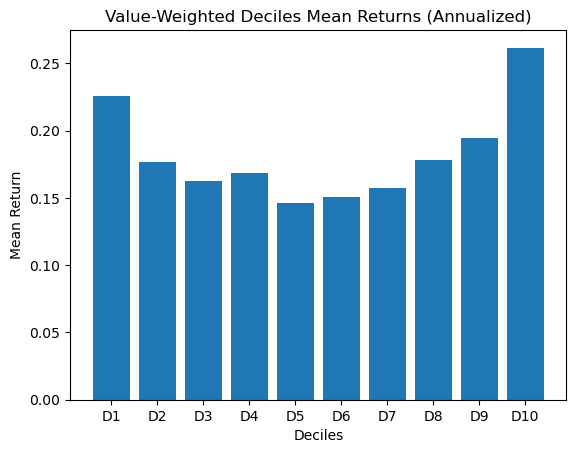

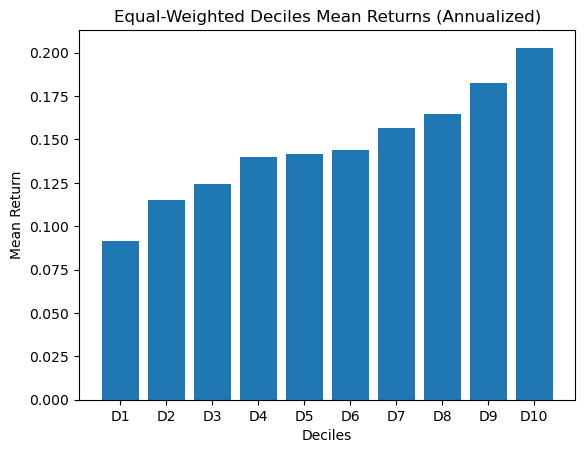

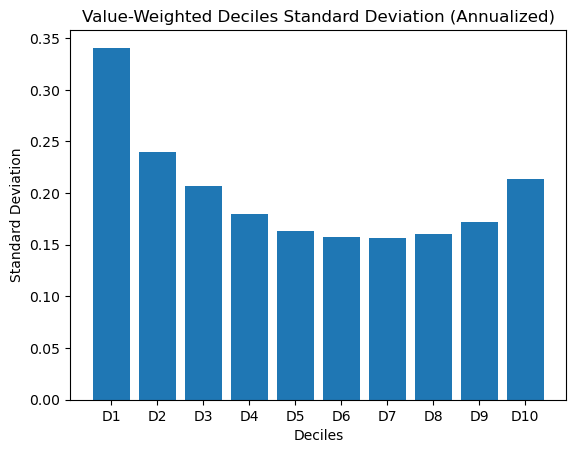

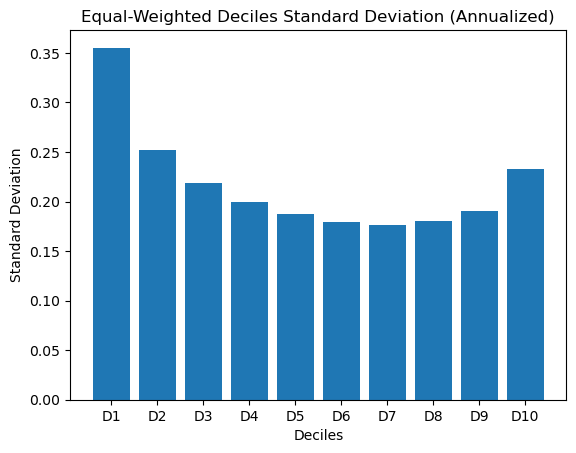

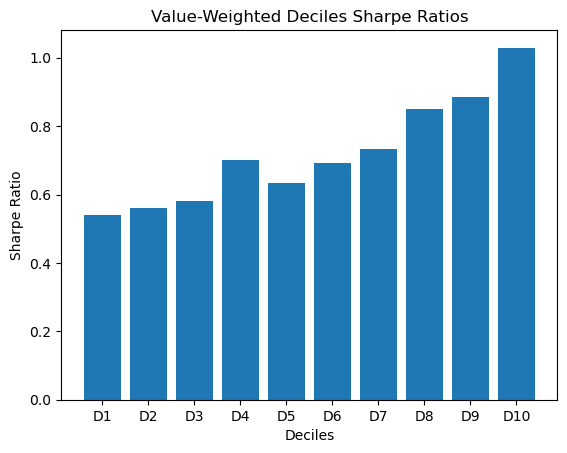

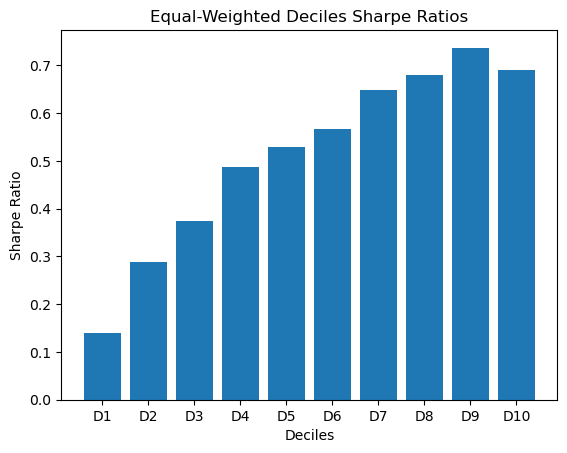

In [15]:
# Calculate standard deviations
vw_ret_std = ret_vw.groupby('Momentum')['MOM_ret_vw'].std()
ew_ret_std = ret_ew.groupby('Momentum')['Rn'].std()

# Calculate Sharpe Ratios

# compute the risk-free rate
rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

# compute the excess returns
ret_vw['excess'] = ret_vw['MOM_ret_vw'] - rf['rf']
ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

# compute the Sharpe Ratios
vw_sharpe_ratio = ret_vw.groupby('Momentum')['excess'].mean() / vw_ret_std
ew_sharpe_ratio = ret_ew.groupby('Momentum')['excess'].mean() / ew_ret_std


# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

directory = 'Plots/Part4/'
#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + 'vw_ret_mean.png')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + 'ew_ret_mean.png')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + 'vw_ret_std.png')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + 'ew_ret_std.png')
plt.show()

# Plot VW Sharpe ratios
plt.bar(deciles, vw_sharpe_ratio * np.sqrt(12))
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + 'vw_sharpe_ratio.png')
plt.show()

# Plot EW Sharpe ratios
plt.bar(deciles, ew_sharpe_ratio * np.sqrt(12))
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + 'ew_sharpe_ratio.png')
plt.show()

### Factor creation

#### Equal-Weighted Long-Short Factor Strategy

In [16]:
# 1. Compute the long and short legs of the strategy
ew_long_leg = data[data['Momentum'] >= 7].groupby('date')['Rn'].mean().reset_index()
ew_short_leg = data[data['Momentum'] < 3].groupby('date')['Rn'].mean().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

ew_long_leg['excess'] = ew_long_leg['Rn'] - rf['rf']
ew_short_leg['excess'] = ew_short_leg['Rn'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = ew_long_leg['Rn'].mean() * 12
short_mean = ew_short_leg['Rn'].mean() * 12

long_mean_e = ew_long_leg['excess'].mean() * 12
short_mean_e = ew_short_leg['excess'].mean() * 12

long_std = ew_long_leg['Rn'].std() * np.sqrt(12)
short_std = ew_short_leg['Rn'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = ew_long_leg.set_index("date") - ew_short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['Rn'] - rf['rf']

factor_mean = factor['Rn'].mean() * 12
factor_mean_e = factor['excess'].mean() * 12
factor_std = factor['Rn'].std() * np.sqrt(12)
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 0.18349772813987653
Short Leg Mean Return: 0.11027267804475926
Long Leg Standard Deviation: 0.19754428425563075
Short Leg Standard Deviation: 0.26801944208572653
Long Leg Sharpe Ratio: 0.6729430761519647
Short Leg Sharpe Ratio: 0.2306584526124965
Factor Mean Return: 0.07322505009511728
Factor Standard Deviation: 0.1675909026499953
Factor Sharpe Ratio: 0.12688503321712993


In [17]:
import scipy.stats as stats

# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')


T-Statistic: 11.625880810436598
P-Value: 0.0
The factor strategy has an average return that is statistically significantly different from zero.


#### Value-Weighted Long-Short Factor Strategy

In [18]:
#1. Compute the long and short legs of the strategy
vw_long_leg = data[data['Momentum'] >= 7].groupby('date')['MOM_ret_vw'].sum().reset_index()
vw_short_leg = data[data['Momentum'] < 3].groupby('date')['MOM_ret_vw'].sum().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

vw_long_leg['excess'] = vw_long_leg['MOM_ret_vw'] - rf['rf']
vw_short_leg['excess'] = vw_short_leg['MOM_ret_vw'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = vw_long_leg['MOM_ret_vw'].mean() * 12
short_mean = vw_short_leg['MOM_ret_vw'].mean() * 12

long_mean_e = vw_long_leg['excess'].mean() * 12
short_mean_e = vw_short_leg['excess'].mean() * 12

long_std = vw_long_leg['MOM_ret_vw'].std() * np.sqrt(12)
short_std = vw_short_leg['MOM_ret_vw'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = vw_long_leg.set_index("date") - vw_short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['MOM_ret_vw'] - rf['rf']

factor_mean = factor['MOM_ret_vw'].mean() * 12
factor_mean_e = factor['excess'].mean() * 12
factor_std = factor['MOM_ret_vw'].std() * np.sqrt(12)
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 0.6340076953377646
Short Leg Mean Return: 0.5653608046375727
Long Leg Standard Deviation: 0.5203218892594204
Short Leg Standard Deviation: 0.7494202595343373
Long Leg Sharpe Ratio: 1.1237936105157902
Short Leg Sharpe Ratio: 0.6791625155060891
Factor Mean Return: 0.06864689070019186
Factor Standard Deviation: 0.6036595189051944
Factor Sharpe Ratio: 0.042914811779374264


In [19]:
# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')

T-Statistic: 3.0258364250406324
P-Value: 0.0012397319966197529
The factor strategy has an average return that is statistically significantly different from zero.


In [20]:
# Storing factor weights for exercise 7

data['w_L'] = (data['Momentum'] >= 7)*data['mcap']
data['w_S'] = (data['Momentum'] <= 2)*data['mcap']
data['w_L'] = data['w_L']/data.groupby(['date'])['w_L'].transform('sum')
data['w_S'] = data['w_S']/data.groupby(['date'])['w_S'].transform('sum')
data['w_Mom'] = data['w_L'] - data['w_S']

factor_weights_mom = data[['date', 'permno', 'w_Mom']]

# merge factor weights mom with factor weights
factor_weights = factor_weights.merge(factor_weights_mom, on=['date', 'permno'], how='left')

In [21]:
# Merge factor dataframe with strat dataframe
strat = strat.merge(factor[['date','MOM_ret_vw']], on='date', how='left')

In [22]:
strat

,date,rf,BAB2,MOM_ret_vw
0,1967-01-01,0.003788,0.074142,-0.244450
1,1967-02-01,0.003737,0.017379,0.076805
2,1967-03-01,0.003385,0.012749,0.049046
3,1967-04-01,0.002877,0.022554,-0.017797
4,1967-05-01,0.002707,0.004873,0.053441
...,...,...,...,...
677,2023-08-01,0.004463,-0.015452,0.172734
678,2023-09-01,0.004472,-0.043764,0.018452
679,2023-10-01,0.004475,0.005450,-0.026999
680,2023-11-01,0.004455,0.034858,0.051445


# 5 Idiosyncratic Volatility Strategy (IV)

In [23]:
data = pd.read_csv("data_with_industries.csv",sep=",")
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.to_period('M')
data['date'] = data['date'].dt.to_timestamp()
# sort the data by date inside each permno
data = data.sort_values(by=['permno','date']).reset_index(drop=True)

In [24]:
# 0. Remove nans
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

# 2. Estimate Rolling Betas
cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(60, min_periods=36).cov()
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

# 3. Merge With data
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
data = pd.merge(data, beta_n, on=['date','permno'], how='left')

# get rid of nan values
data = data.dropna(subset=['beta']).copy()

# 4. Remove outliers
data['beta'] = data['beta'].clip(data['beta'].quantile(0.05),data['beta'].quantile(0.95))

In [25]:
data

,permno,date,Rn,shrout,prc,SIC,mcap,mcap_l,rf,Rm,...,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other,beta
36,10001,2013-01-01,0.062701,8157.0,9.87,4925,80509.59,81080.58,0.000051,0.054142,...,0,0,0,0,1,0,0,0,0,0.464682
37,10001,2013-02-01,0.011651,8157.0,9.94,4925,81080.58,83201.40,0.000040,0.008282,...,0,0,0,0,1,0,0,0,0,0.484416
38,10001,2013-03-01,0.030684,8157.0,10.20,4925,83201.40,86668.70,0.000034,0.035295,...,0,0,0,0,1,0,0,0,0,0.484182
39,10001,2013-04-01,0.017157,8390.0,10.33,4925,86668.70,86249.20,0.000013,0.014939,...,0,0,0,0,1,0,0,0,0,0.487155
40,10001,2013-05-01,-0.000484,8390.0,10.28,4925,86249.20,89064.10,0.000013,0.019128,...,0,0,0,0,1,0,0,0,0,0.487298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420785,93426,2023-08-01,-0.037156,12581.0,36.02,3676,453167.62,367146.00,0.004463,-0.020605,...,0,0,1,0,0,0,0,0,0,1.312988
1420786,93426,2023-09-01,-0.067740,12581.0,33.58,3676,422469.98,395136.96,0.004472,-0.047390,...,0,0,1,0,0,0,0,0,0,1.306562
1420787,93426,2023-10-01,-0.108993,12581.0,29.92,3676,376423.52,405680.64,0.004475,-0.028867,...,0,0,1,0,0,0,0,0,0,1.299385
1420788,93426,2023-11-01,0.019051,12510.0,30.49,3676,381429.90,387805.47,0.004455,0.092057,...,0,0,1,0,0,0,0,0,0,1.300548


In [26]:
# 5. Calculate IV:
# Calculate the predicted return
data['predicted_return_e'] = data['beta'] * data['Rm_e']

# Calculate the residuals
data['residuals'] = data['Rn_e'] - data['predicted_return_e']

# Calculate the rolling standard deviation of the residuals
idiosyncratic_volatility = data.set_index('date').groupby('permno')['residuals'].rolling(window=60, min_periods=36).std()

# Reset the index of the idiosyncratic_volatility Series
idiosyncratic_volatility = idiosyncratic_volatility.reset_index()

# Rename the 0 column to 'idiosyncratic_volatility'
idiosyncratic_volatility = idiosyncratic_volatility.rename(columns={"residuals": 'idiosyncratic_volatility'})

# Merge the idiosyncratic_volatility DataFrame with the original data DataFrame
data = pd.merge(data, idiosyncratic_volatility, on=['date', 'permno'], how='left')

# Drop the intermediate columns
data = data.drop(columns=['predicted_return_e', 'residuals'])

# Drop nans in the idiosyncratic_volatility and beta columns
data = data.dropna(subset=['idiosyncratic_volatility'])

# 4. Remove outliers
data['idiosyncratic_volatility'] = data['idiosyncratic_volatility'].clip(data['idiosyncratic_volatility'].quantile(0.05),data['idiosyncratic_volatility'].quantile(0.95))

In [27]:
data

,permno,date,Rn,shrout,prc,SIC,mcap,mcap_l,rf,Rm,...,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other,beta,idiosyncratic_volatility
35,10001,2015-12-01,-0.132151,10505.0,7.45,4925,78262.25,87401.60,0.000057,-0.022209,...,0,0,0,1,0,0,0,0,0.257529,0.073474
36,10001,2016-01-01,0.116779,10505.0,8.32,4925,87401.60,82569.30,0.000190,-0.057085,...,0,0,0,1,0,0,0,0,0.257529,0.075759
37,10001,2016-02-01,-0.055288,10505.0,7.86,4925,82569.30,82067.48,0.000186,0.000620,...,0,0,0,1,0,0,0,0,0.257529,0.075274
38,10001,2016-03-01,-0.006361,10508.0,7.81,4925,82067.48,76737.60,0.000063,0.070491,...,0,0,0,1,0,0,0,0,0.257529,0.074371
39,10001,2016-04-01,-0.055698,10512.0,7.30,4925,76737.60,75055.68,0.000110,0.011718,...,0,0,0,1,0,0,0,0,0.257529,0.073961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118614,93426,2023-08-01,-0.037156,12581.0,36.02,3676,453167.62,367146.00,0.004463,-0.020605,...,0,1,0,0,0,0,0,0,1.312988,0.064385
1118615,93426,2023-09-01,-0.067740,12581.0,33.58,3676,422469.98,395136.96,0.004472,-0.047390,...,0,1,0,0,0,0,0,0,1.306562,0.062242
1118616,93426,2023-10-01,-0.108993,12581.0,29.92,3676,376423.52,405680.64,0.004475,-0.028867,...,0,1,0,0,0,0,0,0,1.299385,0.062429
1118617,93426,2023-11-01,0.019051,12510.0,30.49,3676,381429.90,387805.47,0.004455,0.092057,...,0,1,0,0,0,0,0,0,1.300548,0.063323


### Sorting

In [28]:
data['IV_Q'] = data.groupby('date')['idiosyncratic_volatility'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

# 2. Market Weights within deciles
data['vw_Q'] = data['mcap']/data.groupby(['date','IV_Q'])['mcap'].transform('sum')

# 3. VW Portfolios
data['IV_ret_vw'] = data['vw_Q']*data['Rn']
ret_vw = data.groupby(['date','IV_Q'])['IV_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('IV_Q')['IV_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date','IV_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('IV_Q')['Rn'].mean()

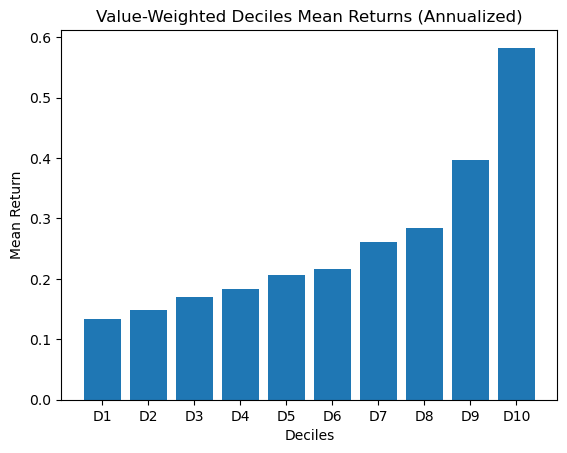

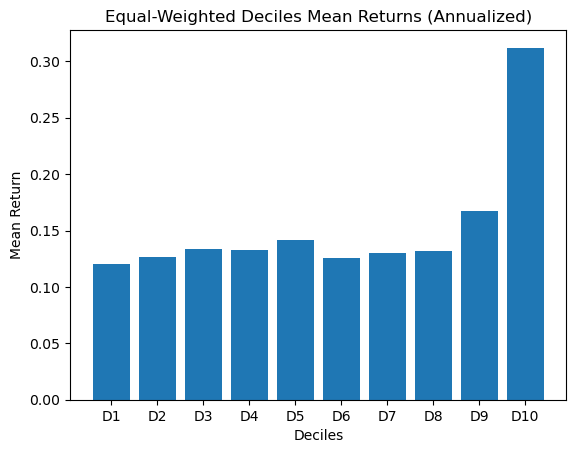

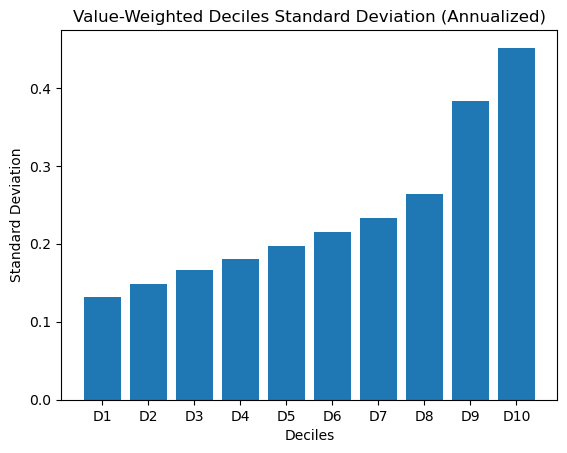

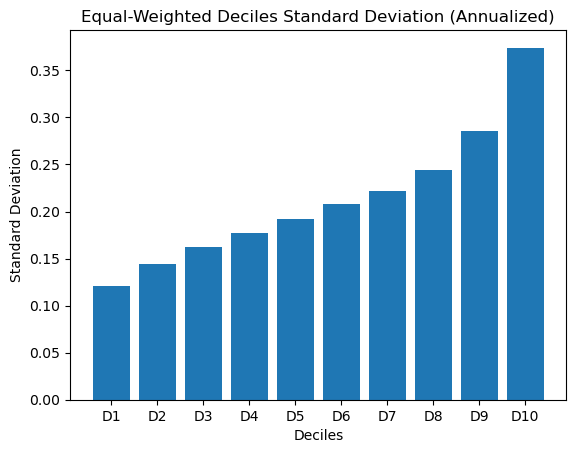

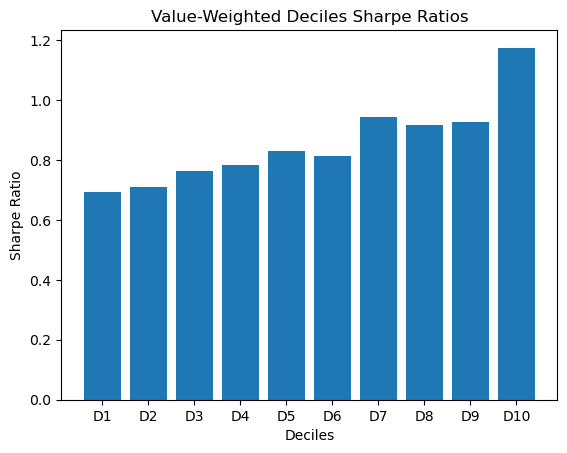

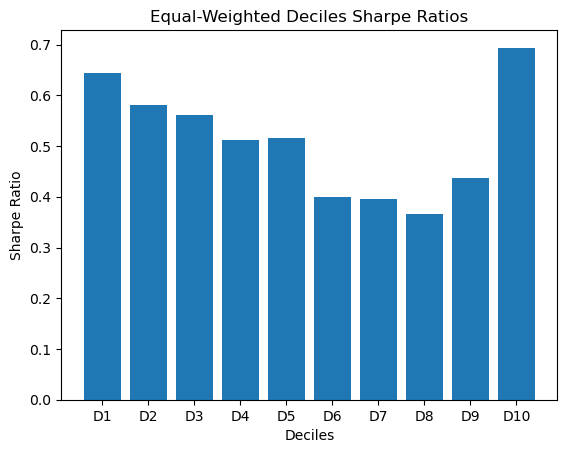

In [29]:
# Calculate standard deviations
vw_ret_std = ret_vw.groupby('IV_Q')['IV_ret_vw'].std()
ew_ret_std = ret_ew.groupby('IV_Q')['Rn'].std()

# Calculate Sharpe Ratios

# compute the risk-free rate
rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

# compute the excess returns
ret_vw['excess'] = ret_vw['IV_ret_vw'] - rf['rf']
ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

# compute the Sharpe Ratios
vw_sharpe_ratio = ret_vw.groupby('IV_Q')['excess'].mean() / vw_ret_std
ew_sharpe_ratio = ret_ew.groupby('IV_Q')['excess'].mean() / ew_ret_std


# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

directory = 'Plots/Part5/'
#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + 'vw_ret_mean.png')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + 'ew_ret_mean.png')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + 'vw_ret_std.png')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + 'ew_ret_std.png')
plt.show()

# Plot VW Sharpe ratios
plt.bar(deciles, vw_sharpe_ratio * np.sqrt(12))
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + 'vw_sharpe_ratio.png')
plt.show()

# Plot EW Sharpe ratios
plt.bar(deciles, ew_sharpe_ratio * np.sqrt(12))
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + 'ew_sharpe_ratio.png')
plt.show()

### Factor creation

Equally weighted factor strategy

In [30]:
# 1. Compute the long and short legs of the strategy
long_leg = data[data['IV_Q'] >= 7].groupby('date')['Rn'].mean().reset_index()
short_leg = data[data['IV_Q'] < 3].groupby('date')['Rn'].mean().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

long_leg['excess'] = long_leg['Rn'] - rf['rf']
short_leg['excess'] = short_leg['Rn'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = long_leg['Rn'].mean() * 12
short_mean = short_leg['Rn'].mean() *12

long_mean_e = long_leg['excess'].mean() *12
short_mean_e = short_leg['excess'].mean() * 12

long_std = long_leg['Rn'].std() * np.sqrt(12)
short_std = short_leg['Rn'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = long_leg.set_index("date") - short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['Rn'] - rf['rf']

factor_mean = factor['Rn'].mean() * 12
factor_mean_e = factor['excess'].mean() * 12
factor_std = factor['Rn'].std() * np.sqrt(12)
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 0.18939980937411477
Short Leg Mean Return: 0.12738082615505525
Long Leg Standard Deviation: 0.28498638643424445
Short Leg Standard Deviation: 0.13874006555639537
Long Leg Sharpe Ratio: 0.46796655752643024
Short Leg Sharpe Ratio: 0.5142358459782497
Factor Mean Return: 0.06201898321905954
Factor Standard Deviation: 0.20257866176737319
Factor Sharpe Ratio: 0.02953554927392046


Save factor for our investing strategy

In [31]:
import scipy.stats as stats

# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')


T-Statistic: 7.787231475901354
P-Value: 3.4416913763379853e-15
The factor strategy has an average return that is statistically significantly different from zero.


Value weighted factor strategy

In [32]:
#1. Compute the long and short legs of the strategy
vw_long_leg = data[data['IV_Q'] >= 7].groupby('date')['IV_ret_vw'].sum().reset_index()
vw_short_leg = data[data['IV_Q'] < 3].groupby('date')['IV_ret_vw'].sum().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

vw_long_leg['excess'] = vw_long_leg['IV_ret_vw'] - rf['rf']
vw_short_leg['excess'] = vw_short_leg['IV_ret_vw'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = vw_long_leg['IV_ret_vw'].mean() * 12
short_mean = vw_short_leg['IV_ret_vw'].mean() * 12

long_mean_e = vw_long_leg['excess'].mean() * 12
short_mean_e = vw_short_leg['excess'].mean() * 12

long_std = vw_long_leg['IV_ret_vw'].std() * np.sqrt(12)
short_std = vw_short_leg['IV_ret_vw'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = vw_long_leg.set_index("date") - vw_short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['IV_ret_vw'] - rf['rf']

factor_mean = factor['IV_ret_vw'].mean()
factor_mean_e = factor['excess'].mean()
factor_std = factor['IV_ret_vw'].std()
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 1.1241912846046542
Short Leg Mean Return: 0.4511256064444506
Long Leg Standard Deviation: 0.9047713003613883
Short Leg Standard Deviation: 0.4337138418834064
Long Leg Sharpe Ratio: 1.180580742343863
Short Leg Sharpe Ratio: 0.9109460135193854
Factor Mean Return: 0.056088806513350305
Factor Standard Deviation: 0.20570606945264386
Factor Sharpe Ratio: 0.24996425264677125


In [33]:
# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')

T-Statistic: 6.935555211668832
P-Value: 2.0231594177744228e-12
The factor strategy has an average return that is statistically significantly different from zero.


In [34]:
# Storing factor weights for exercise 7

data['w_L'] = (data['IV_Q']>= 7)*data['mcap']
data['w_S'] = (data['IV_Q']<=2)*data['mcap']
data['w_L'] = data['w_L']/data.groupby(['date'])['w_L'].transform('sum')
data['w_S'] = data['w_S']/data.groupby(['date'])['w_S'].transform('sum')
data['w_IV'] = data['w_L'] - data['w_S']

factor_weights_iv = data[['date', 'permno', 'w_IV']]

# Drop w_L, w_S and w_IV
data = data.drop(columns=['w_L', 'w_S', 'w_IV'])

# merge factor weights iv with factor weights
factor_weights = factor_weights.merge(factor_weights_iv, on=['date', 'permno'], how='left')

In [35]:
# Merge factor dataframe with strat dataframe

strat = strat.merge(factor[['date','IV_ret_vw']], on='date', how='left')

# Drop all nans
strat = strat.dropna()

In [36]:
# rename columns to IV and MOM
strat = strat.rename(columns={'IV_ret_vw':'IV','MOM_ret_vw':'MOM'})
strat

,date,rf,BAB2,MOM,IV
35,1970-02-01,0.005253,0.028469,0.045441,0.359294
36,1970-03-01,0.005345,0.027225,0.070217,-0.129588
37,1970-04-01,0.005427,-0.040321,0.174635,-0.412564
38,1970-05-01,0.005257,-0.052328,0.005201,-0.127382
39,1970-06-01,0.004942,0.007000,0.201597,-0.100894
...,...,...,...,...,...
677,2023-08-01,0.004463,-0.015452,0.172734,0.027489
678,2023-09-01,0.004472,-0.043764,0.018452,0.027404
679,2023-10-01,0.004475,0.005450,-0.026999,-0.064254
680,2023-11-01,0.004455,0.034858,0.051445,-0.054103


In [37]:
strat.to_csv('strat.csv', sep=';',index=False) # export data

In [38]:
# read csv
strat = pd.read_csv('strat.csv', sep=';')

# 6 Optimal Fund Portfolio Return (STRAT)

In [39]:
# Equal weight strategy
strat['STRAT1'] = (strat['BAB2'] + strat['IV'] + strat['MOM'])/3

# Window size equal to data length
number_of_rows = len(strat)


# Risk-Parity strategy
rolling_vol = strat[['BAB2', 'IV', 'MOM']].rolling(window = 60,min_periods=36).std()
weights = 1 / rolling_vol
# Normalize the weights
weights = weights.div(weights.sum(axis=1), axis=0)
strat['STRAT2'] = (weights['BAB2'] * strat['BAB2'] + weights['IV'] * strat['IV'] + weights['MOM'] * strat['MOM'])
strat['STRAT2_bab_w'] = weights['BAB2']
strat['STRAT2_mom_w'] = weights['MOM']
strat['STRAT2_iv_w'] = weights['IV']

# Mean-variance optimal combination
rolling_mean = strat[['BAB2', 'IV', 'MOM']].rolling(window = 60, min_periods=36).mean()
rolling_cov = strat[['BAB2', 'IV', 'MOM']].rolling(window = 60, min_periods=36).cov()

# w_tan = Cov^(-1) * (mu - Rf * 1) / 1.T * Cov^(-1) * (mu - Rf * 1)

# Iterate over the rolling windows
optimal_weights = []
for i in range(number_of_rows):
    mu = rolling_mean.iloc[i].values
    cov = rolling_cov.loc[rolling_cov.index.get_level_values(0) == i].droplevel(0)
    ones = np.ones(len(mu))
    rf = strat['rf'].iloc[i]
    w_tan = np.linalg.inv(cov).dot((mu - rf * ones)) / (ones.T.dot(np.linalg.inv(cov).dot((mu - rf * ones))))
    optimal_weights.append(w_tan)

optimal_weights = pd.DataFrame(optimal_weights, columns = ['BAB2', 'IV', 'MOM'])
strat['STRAT3'] = (optimal_weights['BAB2'] * strat['BAB2'] + optimal_weights['IV'] * strat['IV'] + optimal_weights['MOM'] * strat['MOM'])

In [40]:
# Calculate the annualized volatility and mean of the STRAT1, STRAT2, and STRAT3 strategies
strat1_mean = strat['STRAT1'].mean() * 12
strat1_std = strat['STRAT1'].std() * np.sqrt(12)
excess_strat1 = strat['STRAT1'] - strat['rf']
strat1_sharpe = excess_strat1.mean() / strat["STRAT1"].std() * np.sqrt(12)

strat2_mean = strat['STRAT2'].mean() * 12
strat2_std = strat['STRAT2'].std() * np.sqrt(12)
excess_strat2 = strat['STRAT2'] - strat['rf']
strat2_sharpe = excess_strat2.mean() / strat["STRAT2"].std() * np.sqrt(12)

strat3_mean = strat['STRAT3'].mean() * 12
strat3_std = strat['STRAT3'].std() * np.sqrt(12)
excess_strat3 = strat['STRAT3'] - strat['rf']
strat3_sharpe = excess_strat3.mean() / strat["STRAT3"].std() * np.sqrt(12)

# Print the results
print('Equal Weighted Strategy:')
print('Mean:', strat1_mean)
print('Standard Deviation:', strat1_std)
print('Sharpe Ratio:', strat1_sharpe)
print("\n")

print('Risk-Parity Strategy:')
print('Mean:', strat2_mean)
print('Standard Deviation:', strat2_std)
print('Sharpe Ratio:', strat2_sharpe)
print("\n")

print('Mean-Variance Optimal Strategy:')
print('Mean:', strat3_mean)
print('Standard Deviation:', strat3_std)
print('Sharpe Ratio:', strat3_sharpe)

Equal Weighted Strategy:
Mean: 0.27165588962225884
Standard Deviation: 0.2628175494563894
Sharpe Ratio: 0.8718678258252269


Risk-Parity Strategy:
Mean: 0.18520151023257236
Standard Deviation: 0.15490605798961485
Sharpe Ratio: 0.9221472996786564


Mean-Variance Optimal Strategy:
Mean: -0.8337158901392436
Standard Deviation: 8.81765699501183
Sharpe Ratio: -0.0993541932724785


In [41]:
# Now find c such that the average annual volatility of the fund is 10% in each case
c1 = 0.1 / strat1_std
c2 = 0.1 / strat2_std
c3 = 0.1 / strat3_std

# Calculate the fund returns
strat['fund1'] = strat['rf'] + c1 * strat['STRAT1']
strat['fund2'] = strat['rf'] + c2 * strat['STRAT2']
strat['fund3'] = strat['rf'] + c3 * strat['STRAT3']

# Calculate the annualized volatility and mean of the fund returns
fund1_mean = strat['fund1'].mean() * 12
fund1_std = strat['fund1'].std() * np.sqrt(12)
excess_fund1 = strat['fund1'] - strat['rf']
fund1_sharpe = excess_fund1.mean() / strat["fund1"].std() * np.sqrt(12)

fund2_mean = strat['fund2'].mean() * 12
fund2_std = strat['fund2'].std() * np.sqrt(12)
excess_fund2 = strat['fund2'] - strat['rf']
fund2_sharpe = excess_fund2.mean() / strat["fund2"].std() * np.sqrt(12)

fund3_mean = strat['fund3'].mean() * 12
fund3_std = strat['fund3'].std() * np.sqrt(12)
excess_fund3 = strat['fund3'] - strat['rf']
fund3_sharpe = excess_fund3.mean() / strat["fund3"].std() * np.sqrt(12)

# Print the results

# Print the c
print('c1:', c1)
print('c2:', c2)
print('c3:', c3)
print("\n")

print('Equal Weighted Fund:')
print('Mean:', fund1_mean)
print('Standard Deviation:', fund1_std)
print('Sharpe Ratio:', fund1_sharpe)
print("\n")

print('Risk-Parity Fund:')
print('Mean:', fund2_mean)
print('Standard Deviation:', fund2_std)
print('Sharpe Ratio:', fund2_sharpe)
print("\n")

print('Mean-Variance Optimal Fund:')
print('Mean:', fund3_mean)
print('Standard Deviation:', fund3_std)
print('Sharpe Ratio:', fund3_sharpe)


c1: 0.38049209501739717
c2: 0.6455525451864779
c3: 0.011340881149785055


Equal Weighted Fund:
Mean: 0.14587664275519066
Standard Deviation: 0.10066310094554436
Sharpe Ratio: 1.026820330342339


Risk-Parity Fund:
Mean: 0.16191261345660024
Standard Deviation: 0.1005077697401933
Sharpe Ratio: 1.1895329745358516


Mean-Variance Optimal Fund:
Mean: 0.03290023433082724
Standard Deviation: 0.10014454103321363
Sharpe Ratio: -0.09441426087938808


In [42]:
strat

,date,rf,BAB2,MOM,IV,STRAT1,STRAT2,STRAT2_bab_w,STRAT2_mom_w,STRAT2_iv_w,STRAT3,fund1,fund2,fund3
0,1970-02-01,0.005253,0.028469,0.045441,0.359294,0.144401,NaN,NaN,NaN,NaN,NaN,0.060196,NaN,NaN
1,1970-03-01,0.005345,0.027225,0.070217,-0.129588,-0.010715,NaN,NaN,NaN,NaN,NaN,0.001268,NaN,NaN
2,1970-04-01,0.005427,-0.040321,0.174635,-0.412564,-0.092750,NaN,NaN,NaN,NaN,NaN,-0.029864,NaN,NaN
3,1970-05-01,0.005257,-0.052328,0.005201,-0.127382,-0.058170,NaN,NaN,NaN,NaN,NaN,-0.016876,NaN,NaN
4,1970-06-01,0.004942,0.007000,0.201597,-0.100894,0.035901,NaN,NaN,NaN,NaN,NaN,0.018602,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642,2023-08-01,0.004463,-0.015452,0.172734,0.027489,0.061590,0.013446,0.775162,0.132489,0.092349,-0.006153,0.027898,0.013144,0.004394
643,2023-09-01,0.004472,-0.043764,0.018452,0.027404,0.000697,-0.028834,0.773422,0.133476,0.093101,-0.053436,0.004737,-0.014142,0.003866
644,2023-10-01,0.004475,0.005450,-0.026999,-0.064254,-0.028601,-0.005305,0.774823,0.132619,0.092558,0.021435,-0.006407,0.001051,0.004718
645,2023-11-01,0.004455,0.034858,0.051445,-0.054103,0.010733,0.028765,0.773802,0.132925,0.093273,0.064940,0.008539,0.023024,0.005191


# 7 Performance and risk analysis for the Fund strategy

### 7B

In [43]:
industries =['NoDur',
 'Durbl',
 'Manuf',
 'Enrgy',
 'Chems',
 'BusEq',
 'Telcm',
 'Utils',
 'Shops',
 'Hlth',
 'Money',
 'Other']

In [44]:
# Drop every nan value in factor_weights
factor_weights = factor_weights.dropna()

# Merge factor weights with data
data = data.merge(factor_weights, on=['date', 'permno'], how='left')
data

,permno,date,Rn,shrout,prc,SIC,mcap,mcap_l,rf,Rm,...,Money,Other,beta,idiosyncratic_volatility,IV_Q,vw_Q,IV_ret_vw,w_bab,w_Mom,w_IV
0,10001,2015-12-01,-0.132151,10505.0,7.45,4925,78262.25,87401.60,0.000057,-0.022209,...,0,0,0.257529,0.073474,4,0.000102,-1.349280e-05,0.002618,-0.000059,0.000000
1,10001,2016-01-01,0.116779,10505.0,8.32,4925,87401.60,82569.30,0.000190,-0.057085,...,0,0,0.257529,0.075759,4,0.000142,1.653816e-05,0.002653,0.000000,0.000000
2,10001,2016-02-01,-0.055288,10505.0,7.86,4925,82569.30,82067.48,0.000186,0.000620,...,0,0,0.257529,0.075274,4,0.000129,-7.155642e-06,0.002674,0.000000,0.000000
3,10001,2016-03-01,-0.006361,10508.0,7.81,4925,82067.48,76737.60,0.000063,0.070491,...,0,0,0.257529,0.074371,4,0.000122,-7.753482e-07,0.002672,0.000000,0.000000
4,10001,2016-04-01,-0.055698,10512.0,7.30,4925,76737.60,75055.68,0.000110,0.011718,...,0,0,0.257529,0.073961,4,0.000106,-5.922128e-06,0.002705,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899754,93426,2023-08-01,-0.037156,12581.0,36.02,3676,453167.62,367146.00,0.004463,-0.020605,...,0,0,1.312988,0.064385,2,0.000188,-6.979925e-06,0.000623,0.000060,-0.000033
899755,93426,2023-09-01,-0.067740,12581.0,33.58,3676,422469.98,395136.96,0.004472,-0.047390,...,0,0,1.306562,0.062242,1,0.000122,-8.294669e-06,0.000633,0.000000,-0.000033
899756,93426,2023-10-01,-0.108993,12581.0,29.92,3676,376423.52,405680.64,0.004475,-0.028867,...,0,0,1.299385,0.062429,1,0.000104,-1.133331e-05,0.000636,0.000000,-0.000030
899757,93426,2023-11-01,0.019051,12510.0,30.49,3676,381429.90,387805.47,0.004455,0.092057,...,0,0,1.300548,0.063323,2,0.000181,3.445942e-06,0.000639,0.000000,-0.000028


In [45]:
# Calculate the beta of each factor at each time t
data['beta_BAB2'] = data['beta'] * data['w_bab']
data['beta_IV'] = data['beta'] * data['w_IV']
data['beta_MOM'] = data['beta'] * data['w_Mom']

# Calculate the weighted beta of each industry at each time t by iterating through industries
for industry in industries:
    data[industry+"_bab"] = data[industry] * data['w_bab']
    data[industry+"_iv"] = data[industry] * data['w_IV']
    data[industry+"_mom"] = data[industry] * data['w_Mom']

# Create temporary dataframe to store the factor betas
tmp = data[['date','permno', 'beta_BAB2', 'beta_IV', 'beta_MOM']].copy()

# Add industries to tmp
for industry in industries:
    tmp[industry+"_bab"] = data[industry+"_bab"]
    tmp[industry+"_iv"] = data[industry+"_iv"]
    tmp[industry+"_mom"] = data[industry+"_mom"]

# Compute the new beta as the sum of each weighted beta at each time t
tmp['beta_BAB2'] = tmp.groupby('date')['beta_BAB2'].transform('sum')
tmp['beta_IV'] = tmp.groupby('date')['beta_IV'].transform('sum')
tmp['beta_MOM'] = tmp.groupby('date')['beta_MOM'].transform('sum')

# Compute the new beta for each industry at each time t
for industry in industries:
    tmp[industry+"_bab"] = tmp.groupby('date')[industry+"_bab"].transform('sum')
    tmp[industry+"_iv"] = tmp.groupby('date')[industry+"_iv"].transform('sum')
    tmp[industry+"_mom"] = tmp.groupby('date')[industry+"_mom"].transform('sum')

# Convert 'date' column to datetime in both dataframes
strat['date'] = pd.to_datetime(strat['date'])
tmp['date'] = pd.to_datetime(tmp['date'])

# Drop column permno
tmp = tmp.drop(columns=['permno'])

# Merge tmp with strat on date
strat = strat.merge(tmp, on='date', how='left')

# Drop duplicates in strat
strat = strat.drop_duplicates()

# Drop every nan value in strat
strat = strat.dropna()
strat = strat.reset_index()


In [49]:
# Compute the STRAT2 betas of the market and the industries
# (The market beta of the BAB factor is 0)
strat["STRAT2_BETA_MKT"] = c2*(strat["STRAT2_bab_w"] * 0 + strat["STRAT2_iv_w"] * strat["beta_IV"] + strat["STRAT2_mom_w"] * strat["beta_MOM"])

for industry in industries:
    strat["STRAT2_BETA_" + industry] = c2*(strat["STRAT2_bab_w"] * strat[industry + "_bab"] + strat["STRAT2_iv_w"] * strat[industry + "_iv"] + strat["STRAT2_mom_w"] * strat[industry + "_mom"])

In [50]:
strat

,index,date,rf,BAB2,MOM,IV,STRAT1,STRAT2,STRAT2_bab_w,STRAT2_mom_w,...,STRAT2_BETA_Manuf,STRAT2_BETA_Enrgy,STRAT2_BETA_Chems,STRAT2_BETA_BusEq,STRAT2_BETA_Telcm,STRAT2_BETA_Utils,STRAT2_BETA_Shops,STRAT2_BETA_Hlth,STRAT2_BETA_Money,STRAT2_BETA_Other
0,49320,1973-01-01,0.004643,0.005983,0.206780,-0.107747,0.035005,0.016888,0.798897,0.107389,...,0.104455,0.025723,0.020333,0.018473,0.010251,0.054838,0.032624,0.012171,0.021770,0.052810
1,50880,1973-02-01,0.004650,-0.000984,0.138434,-0.111638,0.008604,0.003579,0.799576,0.106930,...,0.104937,0.023950,0.019533,0.020666,0.008409,0.055265,0.035525,0.010710,0.020608,0.052610
2,52438,1973-03-01,0.004896,-0.009443,0.076781,0.012613,0.026650,0.001897,0.798467,0.107444,...,0.103017,0.028001,0.020076,0.021479,0.008522,0.056571,0.035657,0.010485,0.021490,0.047234
3,53997,1973-04-01,0.004989,0.004420,0.235758,-0.132923,0.035752,0.015947,0.800800,0.105473,...,0.101697,0.029339,0.020319,0.023331,0.006717,0.057640,0.035454,0.010819,0.021616,0.047309
4,55559,1973-05-01,0.005439,-0.002591,0.267544,-0.241819,0.007711,0.003253,0.804158,0.103453,...,0.103327,0.028930,0.020930,0.022162,0.006598,0.059779,0.031916,0.010801,0.022041,0.051066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,894550,2023-08-01,0.004463,-0.015452,0.172734,0.027489,0.061590,0.013446,0.775162,0.132489,...,0.062437,0.045709,0.017181,0.037148,-0.002180,0.036735,0.057830,0.038482,0.052116,0.065020
608,895609,2023-09-01,0.004472,-0.043764,0.018452,0.027404,0.000697,-0.028834,0.773422,0.133476,...,0.063279,0.045944,0.015409,0.044951,-0.004330,0.026197,0.047562,0.039539,0.064357,0.067806
609,896666,2023-10-01,0.004475,0.005450,-0.026999,-0.064254,-0.028601,-0.005305,0.774823,0.132619,...,0.063049,0.050381,0.016392,0.044072,0.005444,0.030588,0.044859,0.034395,0.046630,0.075696
610,897721,2023-11-01,0.004455,0.034858,0.051445,-0.054103,0.010733,0.028765,0.773802,0.132925,...,0.059610,0.047503,0.017735,0.041878,0.004712,0.031711,0.045047,0.033366,0.056967,0.070978
